In [ ]:
%matplotlib inline

In [1]:
import MDAnalysis as mda
import ARPDF, utils, search_boxes
import importlib
import matplotlib.pyplot as plt
import torch
importlib.reload(search_boxes)
importlib.reload(ARPDF)
importlib.reload(utils)
from ARPDF import *
from utils import *
from search_boxes_CH3CN import StructureSearcher
from ccl4_modifier import CCL4Modifier_C_CL, select_cl_atoms
from ch3cn_modifier import CH3CNAngleSampler, CH3CNAngle_LengthSampler, select_n_atoms

/opt/mamba/envs/arpdf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/mamba/envs/arpdf/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
u1, u2, modified_atoms, polar_axis = load_structure_data('data/CH3CN/')
X, Y = generate_grids(10, 256)
filter_fourier = lambda kX, kY, xp: xp.ones_like(kX)
# filter_fourier = lambda kX, kY, xp: (1 - xp.exp(-(kX**2 / 0.3 + kY**2 / 0.1)))**3 * xp.exp(-0.08 * (kX**2 + kY**2))
print(modified_atoms)
sigma0 = 0.2
neg = False
print(f"sigma0 = {sigma0}, neg = {neg}")

[721, 722, 723]
sigma0 = 0.2, neg = False


Using cupy to compute ARPDF...
Selected 492 atoms for universe 1, 492 atoms for universe 2.
Computing fields of universe 1...
Computed field for C-C: 410 atom pairs.
Computed field for C-N: 409 atom pairs.
Computed field for N-N: 99 atom pairs.
Computing fields of universe 2...
Computed field for C-C: 409 atom pairs.
Computed field for C-N: 412 atom pairs.
Computed field for N-N: 98 atom pairs.
Computing ARPDF...


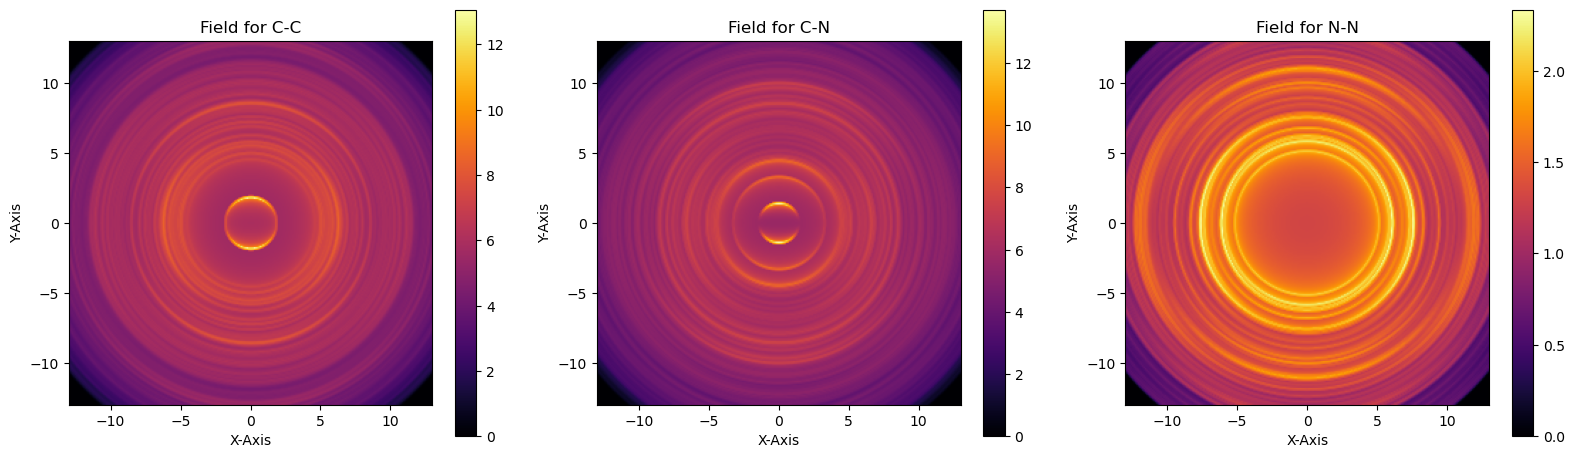

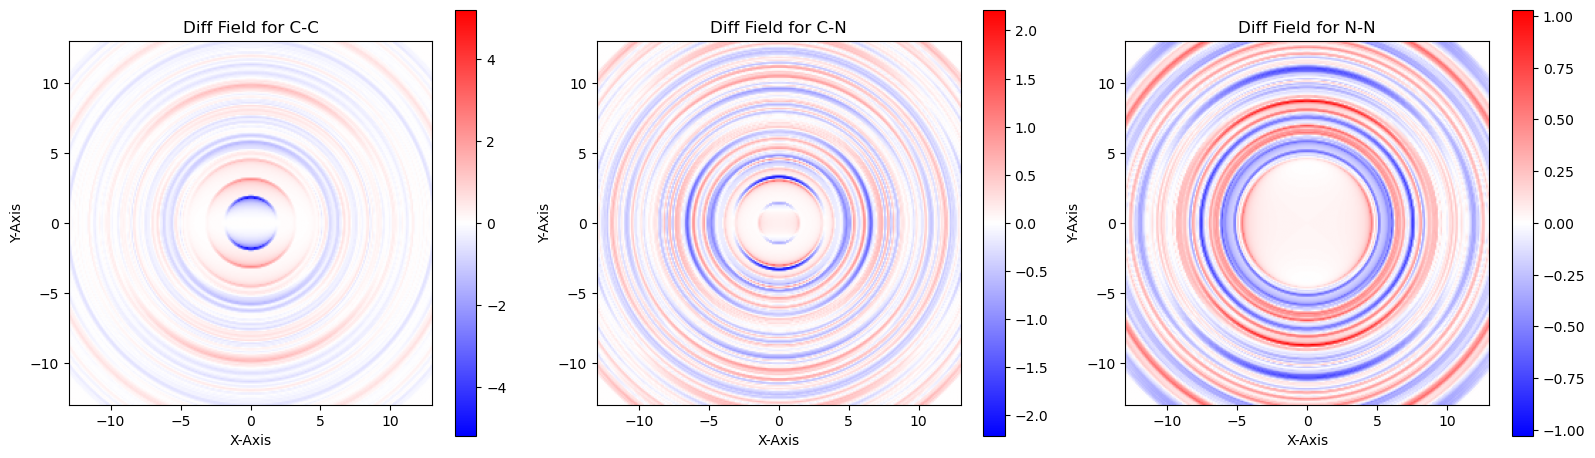

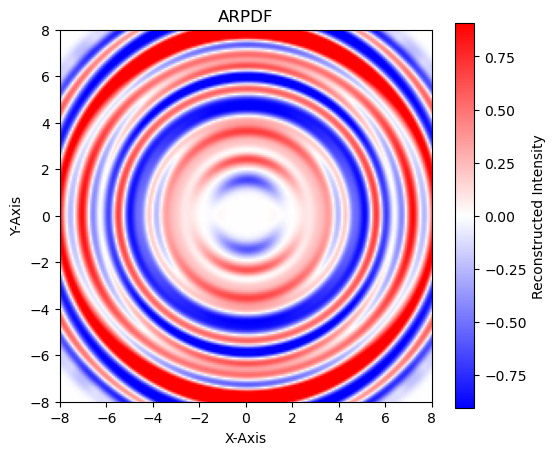

In [3]:
ARPDF_ref = compute_ARPDF(u1, u2, N=512, cutoff=13.0, sigma0=sigma0, grids_XY=(X, Y), modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, filter_fourier=filter_fourier, verbose=True)

In [6]:
def workflow_for_opt(
        X, Y, ARPDF_ref, 
        filter_fourier=None, 
        sigma0=0.2, 
        exp_name: str="exp_ch3cn_rotate_angular_scale_3nm_flat_cutoff_5", 
        metric: str="angular_scale", 
        weight_cutoff=5.0, 
        stretch_distances: List[float] = None,
        neg=False
    ):
    """Demo workflow for structure search and analysis"""
    # Clean and load structure
    clean_gro_box('data/CH3CN/CH3CN_no_H.gro', 'data/CH3CN/CH3CN_no_H_clean.gro')
    universe = mda.Universe('data/CH3CN/CH3CN_no_H_clean.gro')
    if neg:
        ARPDF_ref = ARPDF_ref.copy()
        ARPDF_ref[ARPDF_ref > 0] = 0
    
    # Initialize searcher with CCl4-specific components
    searcher = StructureSearcher(
        output_dir=f"tmp/{exp_name}",
        universe=universe,
        grids_XY=(X, Y),
        ARPDF_ref=ARPDF_ref,
        molecule_selector=select_n_atoms,
        structure_modifier=CH3CNAngle_LengthSampler(universe, stretch_distances, periodic=True),
        filter_fourier=filter_fourier,
        sigma0=sigma0,
        metric=metric,
        weight_cutoff=weight_cutoff,
        neg=neg
    )
    
    # Search and save results
    searcher.search()
    searcher.save_results()

已生成过滤并重命名后的文件: data/CH3CN/CH3CN_no_H_clean.gro


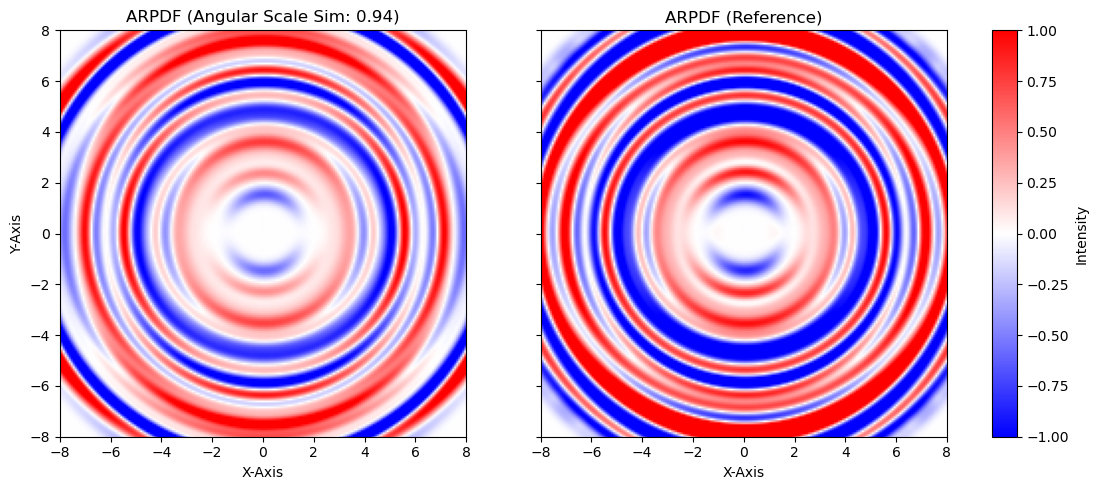

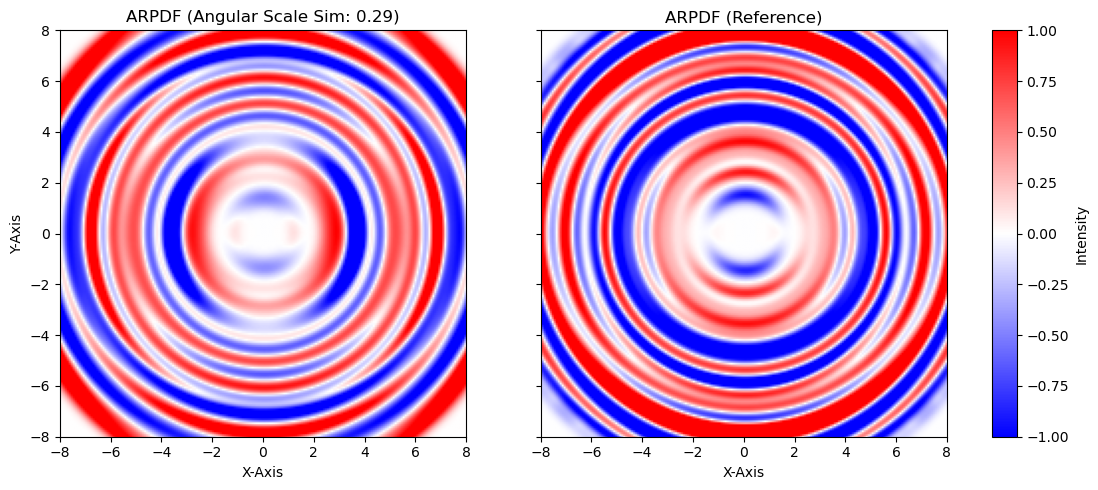

In [7]:
workflow_for_opt(
    X, Y, ARPDF_ref, 
    filter_fourier, 
    sigma0, 
    exp_name="exp_ch3cn_rotate_angular_scale_3nm_cutoff_5", 
    metric="angular_scale", 
    #stretch_distances=[round(1.0 + 0.1 * i, 1) for i in range(15)], 
    weight_cutoff=5.0, 
    neg=neg
)

In [ ]:
# workflow_for_opt(
#     X, Y, ARPDF_ref, 
#     filter_fourier, 
#     sigma0, 
#     exp_name="exp_opt_cosine", 
#     metric="cosine", 
#     stretch_distances=[round(1.0 + 0.1 * i, 1) for i in range(15)], 
#     weight_cutoff=5.0, 
#     neg=neg
# )